# Stocks calibration: TSLA

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
import scipy.optimize as scpo
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import sys
sys.path.append('C:/Users\ornel\PycharmProjects\Margin-Loans-Pricing/functions')
sys.path.append('C:/Users/ornel/PycharmProjects/Margin-Loans-Pricing/calibration')
import warnings
import time

warnings.simplefilter(action='ignore', category=FutureWarning)

from BSpricer import BS_Pricer
from MERTONpricer import Merton_pricer
from KOUpricer import Kou_pricer
from VGpricer import VG_pricer

np.random.seed(110)

In [116]:
otko_spx = pd.read_csv('../../data/SPX/otko_spx_1year.csv')
print('>> SPX')
print(otko_spx)

scale_factors = {
    'AAPL': 7.84,
    'META': 6.23,
    'TSLA': 9.35,
    'NVDA': 10.7
}
columns = ['BID(%)', 'ASK(%)', 'Midpoint(%)']

# FIND PRICES OF OTKO OPTIONS ACCORDING to their scale factors
otko_tsla = otko_spx.copy()

otko_tsla[columns] = round(otko_tsla[columns]*scale_factors['TSLA'],2)
otko_tsla['Stock Name'] = 'TSLA'
print(f'>> TSLA\n {otko_tsla}')
#otko_tsla.to_csv('../../data/TSLA/tsla_otko_1year.csv', index=False)


>> SPX
  Starting date Stock Name Expiry  K1  K2  BID(%)  Midpoint(%)  ASK(%)
0    20/01/2016        SPX     1Y  75   0    0.17        0.185    0.20
1    20/01/2016        SPX     1Y  70   0    0.08        0.090    0.10
2    20/01/2016        SPX     1Y  85  75    0.34        0.370    0.40
3    20/01/2016        SPX     1Y  80  70    0.24        0.260    0.28
4    20/01/2016        SPX     1Y  90  80    0.48        0.510    0.54
>> TSLA
   Starting date Stock Name Expiry  K1  K2  BID(%)  Midpoint(%)  ASK(%)
0    20/01/2016       TSLA     1Y  75   0    1.59         1.73    1.87
1    20/01/2016       TSLA     1Y  70   0    0.75         0.84    0.94
2    20/01/2016       TSLA     1Y  85  75    3.18         3.46    3.74
3    20/01/2016       TSLA     1Y  80  70    2.24         2.43    2.62
4    20/01/2016       TSLA     1Y  90  80    4.49         4.77    5.05


In [14]:
# Define the instruments to download.
tickers = ['TSLA']      # AAPL, META, TSLA, MSFT, NVDA, GOOG

######## FIRST TIME, THEN SAVED INTO A CSV FILE ##########
# Take all available data from 20/01/2016 until 20/01/2018.
start_date = datetime(2016, 1, 20)
end_date = datetime(2018, 1, 20)

# Use pandas_reader.data.DataReader to load the data.
stocks_data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)
#spx_data = yf.download('^GSPC', start=start_date, end=end_date, auto_adjust=True)

print(stocks_data.head(3))

S0 = stocks_data.loc['2016-01-20', 'Close']
print(S0)

[*********************100%%**********************]  1 of 1 completed
                 Open       High        Low      Close    Volume
Date                                                            
2016-01-20  13.293333  13.418667  12.750000  13.246667  87579000
2016-01-21  13.436667  13.548667  13.001333  13.331333  47493000
2016-01-22  13.653333  13.700000  13.268667  13.503333  46861500
13.24666690826416


### Calibration of model parameters
The following code snippet perfoms calibration of the models parameters using closed forms.
If we define $\Theta$ the set of parameters, the goal is to find the optimal parameters $\Theta^*$ that minimize the following objective function:
$$ \sum_{i=1}^{N} w_i \biggl( P_i - f(K_i|\Theta) \biggr)^2 $$
where $w_i$ are weights, usually defined as
$$ w_i = \frac{1}{\text {spread}_i ^2},$$ $P_i$ are the market prices and $f$ is the pricing function, $f$ given by **Merton** Jump Diffusion model, **Kou** Jump Diffusion model, or **Variance Gamma** process. The optimization problem is carried out using the module *least_squares* of the library `scipy.optimize`.
Let's define the spread first.

#### TSLA PRICES

In [15]:
r = 0.03
T = 1
q = 0
exercise = 'european'
paths = 1000
days = 252

# BOOK:  Financial modelling with jump processes  PAG 442
strikes = otko_spx[['K1', 'K2']].values / 100
weights =  1/(otko_tsla['ASK(%)'] - otko_tsla['BID(%)'])**2
mkt_prices = otko_tsla['Midpoint(%)'].values

##### Merton Jump Diffusion model

In [46]:
x0 = [0.3352, 1.4, -0.4, 1.4]
bounds = ( [1e-1, 0, -2, 0], [0.9, 5, 2, 4] )

def cost_function(x, strikes, mkt_prices):
    sigma, lambd, meanJ, stdJ = x
    M = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
    sq_err = 0
    for k in range(len(strikes)):
        sq_err +=  weights[k]*(M.closed_formula_otko(strikes[k][0], strikes[k][1]) - mkt_prices[k])**2
    return sq_err

start = time.time()
mert = scpo.least_squares(cost_function, x0, args=(strikes, mkt_prices), bounds=bounds, method = 'trf', verbose=1)
end = time.time()

mert_params_calibrated = [round(p,4) for p in mert.x[:4]]

The maximum number of function evaluations is exceeded.
Function evaluations 400, initial cost 1.2996e+08, final cost 5.9765e-03, first-order optimality 3.35e-02.


In [47]:
print('\nMETHOD: LEAST SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {mert_params_calibrated[0]} \t {round(mert_params_calibrated[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert_params_calibrated[1],2))
print('> Calibrated Jump Mean = ', round(mert_params_calibrated[2],3))
print('> Calibrated Jump St. dev.  = ', round(mert_params_calibrated[3],3))
print(f'TIME ELAPSED:  {round(end-start,2)} sec')


METHOD: LEAST SQUARES (trf)
> Calibrated Volatlity [σ] = 0.3352 	 33.52%
> Calibrated Jump intensity [λ] =  2.03
> Calibrated Jump Mean =  -0.097
> Calibrated Jump St. dev.  =  0.186
TIME ELAPSED:  4.3 sec


In [48]:
print(f'CALIBRATED PARAMETERS [σ\t\tλ\t\tm\t\tv]')
print(f'> OTKO DC:\t\t\t {mert_params_calibrated}')
otko_mert_params_tsla = mert_params_calibrated
%store otko_mert_params_tsla

CALIBRATED PARAMETERS [σ		λ		m		v]
> OTKO DC:			 [0.3352, 2.0253, -0.097, 0.1857]
Stored 'otko_mert_params_tsla' (list)


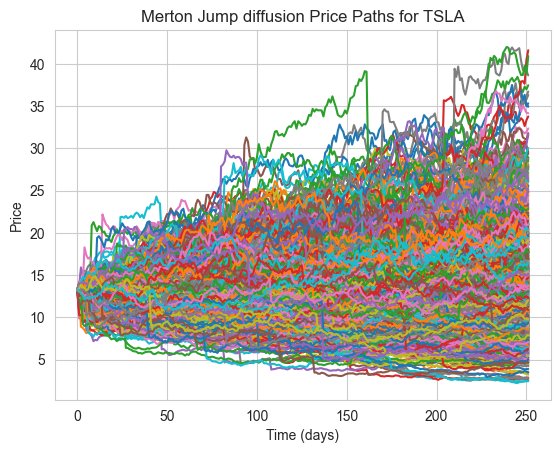

<Figure size 1000x600 with 0 Axes>

In [49]:
sigma_c, lambd_c, meanJ_c, stdJ_c = mert_params_calibrated
MERT_CAL = Merton_pricer(S0, None, T, r, q, sigma_c, lambd_c, meanJ_c, stdJ_c, exercise)
SMerton_CAL = MERT_CAL.MertonPath(days, paths)
MERT_CAL.plotMertonPath(SMerton_CAL, 'TSLA')

##### Kou Double Exponential Jump Diffusion model

In [98]:
# initial guess: [σ, λ, p, η_1, η_2]
x0 =[0.3112, 1.9, 0.45, 11.234, 6.21]
bounds = ( [1e-1, 0.1, 0.1, 0, 0], [0.8, 5, 0.9, 20, 20] )

# Define the objective function
def cost_function(x, strikes, mkt_prices):
    sigm, lamb, p, eta1, eta2 = x
    KOU = Kou_pricer(S0=S0, K=strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    sq_err = 0
    for k in [0,1,2,3,4]:
        sq_err += weights[k]*(KOU.closed_formula_otko(strikes[k][0], strikes[k][1]) - mkt_prices[k]) ** 2
    return sq_err

start2=time.time()
kou2 = scpo.least_squares(cost_function, x0, args=(strikes, mkt_prices),  method='trf', bounds=bounds, verbose=1, loss='soft_l1')
end2=time.time()

kou_params_calibrated = kou2.x[:5]

The maximum number of function evaluations is exceeded.
Function evaluations 500, initial cost 2.1101e+01, final cost 2.6888e-02, first-order optimality 1.07e-01.


In [99]:
print('METHOD 2: Least-squares')
print(f'> Calibrated Volatlity [σ] = {round(kou_params_calibrated[0],4)} \t {round(kou_params_calibrated[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(kou_params_calibrated[1],2))
print(f'> Calibrated Upward Jump probability [p] = {round(kou_params_calibrated[2],2)}, [q] = {round(1-kou_params_calibrated[2],2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(kou_params_calibrated[3],2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(kou_params_calibrated[4],2))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

METHOD 2: Least-squares
> Calibrated Volatlity [σ] = 0.3112 	 31.12%
> Calibrated Jump intensity [λ] =  4.72
> Calibrated Upward Jump probability [p] = 0.1, [q] = 0.9
> Calibrated Rate of Exp. 1  [η_1] =  11.23
> Calibrated Rate of Exp. 2  [η_2] =  9.46
TIME ELAPSED:  0.32 sec


In [100]:
print(f'CALIBRATED PARAMETERS:\t [σ\t\tλ\t\tp\t\tη1\t η2\t   ]')
print(f'> OTKO DC:\t\t\t\t {[round(p,4) for p in kou_params_calibrated]}')
otko_kou_params_tsla = kou_params_calibrated
%store otko_kou_params_tsla

CALIBRATED PARAMETERS:	 [σ		λ		p		η1	 η2	   ]
> OTKO DC:				 [0.3112, 4.718, 0.1, 11.234, 9.4628]
Stored 'otko_kou_params_tsla' (ndarray)


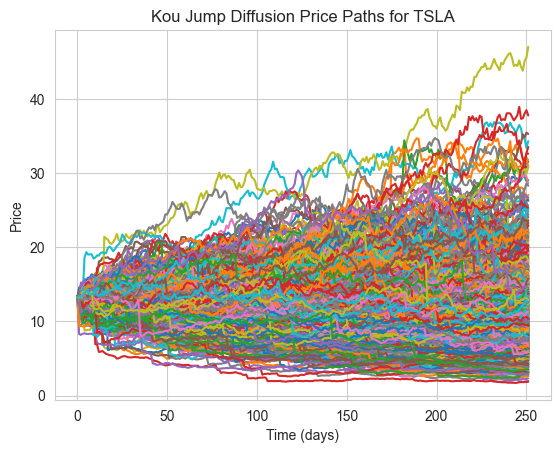

<Figure size 1000x600 with 0 Axes>

In [101]:
sigma, lambd, p, eta1, eta2 = kou_params_calibrated
KOU_CAL = Kou_pricer(S0, None, T, r, sigma, lambd, p, eta1, eta2, exercise)
SKou_cal = KOU_CAL.KouPath(days, paths)
KOU_CAL.plotKouPath(SKou_cal, 'TSLA')

##### Variance Gamma model

In [102]:
x0 =[0.2812, -0.11, 0.46]  # initial guess: [σ, θ, v]
bounds = ( [1e-3, -1, 0], [0.8, 1, 3] )

def cost_function(x, strikes, mkt_prices):
    sigma, theta, nu = x
    VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
    sq_err = 0
    for k in range(len(strikes)): 
        sq_err += weights[k]*(VG.closed_formula_otko6(strikes[k][0], strikes[k][1]) - mkt_prices[k]) ** 2
    return sq_err

start3=time.time()
vg = scpo.least_squares(cost_function, x0, args=(strikes, mkt_prices),  method='trf', bounds=bounds, verbose=1)
end3=time.time()

vg_params_calibrated = [round(p,4) for p in vg.x[:3]]

The maximum number of function evaluations is exceeded.
Function evaluations 300, initial cost 3.5560e+02, final cost 2.4501e-02, first-order optimality 1.31e-01.


In [103]:
print('METHOD 1: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {vg_params_calibrated[0]}, \t {round(vg_params_calibrated[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params_calibrated[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params_calibrated[2])
print(f'TIME ELAPSED:  {round(end3-start3,2)} sec')

METHOD 1: LEAST-SQUARES (trf)
> Calibrated Volatlity [σ] = 0.4559, 	 45.59%
> Calibrated mean rate gamma process [θ] =  -0.1983
> Calibrated variance rate gamma process [v]=  0.1336
TIME ELAPSED:  0.35 sec


In [104]:
print(f'CALIBRATED PARAMETERS: [σ \t\tθ\t\t v]')
print(f'> OTKO DC:\t\t\t {vg_params_calibrated}')
otko_vg_params_tsla = vg_params_calibrated
%store otko_vg_params_tsla

CALIBRATED PARAMETERS: [σ 		θ		 v]
> OTKO DC:			 [0.4559, -0.1983, 0.1336]
Stored 'otko_vg_params_tsla' (list)


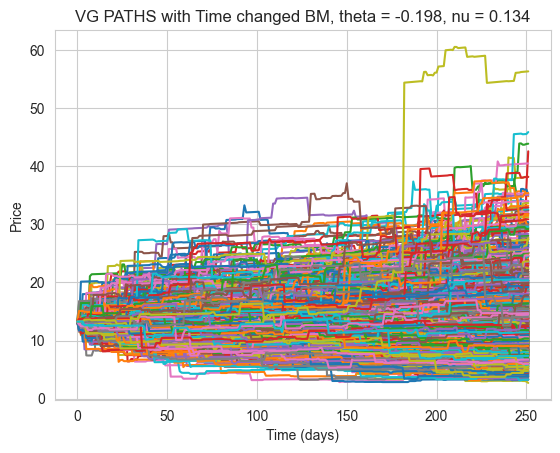

<Figure size 800x600 with 0 Axes>

In [105]:
sigma, theta, nu = vg_params_calibrated
VG_CAL = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
SVarGamma_cal = VG_CAL.VarianceGammaPath1(days, paths)
VG_CAL.plotVGPath(SVarGamma_cal, 'TSLA', 'Time changed BM')

### Repricing options with calibrated parameters

In [106]:
calibrated_prices = pd.DataFrame({
    'K1': otko_tsla['K1'],
    'K2': otko_tsla['K2'],
    'MKT_BID (%)': otko_tsla['BID(%)'],
    'MKT_MID (%)': otko_tsla['Midpoint(%)'],
    'MKT_ASK (%)': otko_tsla['ASK(%)']
})
print(f'MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. \n\n{calibrated_prices}')

MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. 

   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)
0  75   0         1.59         1.73         1.87
1  70   0         0.75         0.84         0.94
2  85  75         3.18         3.46         3.74
3  80  70         2.24         2.43         2.62
4  90  80         4.49         4.77         5.05


##### Merton Jump diffusion


In [107]:
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SMerton_CAL.T:
        payoffs.append(MERT_CAL.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(calibrated_prices))
merton_cf_prices = np.zeros(len(calibrated_prices))

for index in range(len(calibrated_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    merton_cf_prices[index] = MERT_CAL.closed_formula_otko(strikes[index][0], strikes[index][1])

calibrated_prices['MERTON MC (%)'] = [round(p,2) for p in merton_mc_prices]
calibrated_prices['MERTON CF (%)'] = [round(p,2) for p in merton_cf_prices]

##### Kou Double Exponential Jump diffusion

In [108]:
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SKou_cal.T:
        payoffs.append(KOU_CAL.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(calibrated_prices))
kou_cf_prices = np.zeros(len(calibrated_prices))

for index in range(len(calibrated_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    kou_cf_prices[index] = KOU_CAL.closed_formula_otko(strikes[index][0], strikes[index][1])

calibrated_prices['KOU MC (%)'] = [round(p,2) for p in kou_mc_prices]
calibrated_prices['KOU CF (%)'] = [round(p,2) for p in kou_cf_prices]

##### Variance Gamma Jump diffusion

In [109]:
avg_payoffs3 = []
for K1, K2 in strikes:
    payoffs3 = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SVarGamma_cal.T:
        payoffs3.append(VG_CAL.payoff_otko(path, K1, K2))
    avg_payoffs3.append(np.mean(payoffs3))

vg_mc_prices = np.zeros(len(calibrated_prices))
vg_cf_prices = np.zeros(len(calibrated_prices))

for index in range(len(calibrated_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs3[index] *100
    vg_cf_prices[index] = VG_CAL.closed_formula_otko6(strikes[index][0], strikes[index][1])

calibrated_prices['VG MC (%)'] = [round(p,2) for p in vg_mc_prices]
calibrated_prices['VG CF (%)'] = [round(p,2) for p in vg_cf_prices]

In [110]:
print(f'>> SPX OTKO OPTIONS REPRICED WITH CALIBRATED PARAMETERS\nMC = Monte Carlo pricing\nCF = Closed Formulas pricing\n')
print(calibrated_prices)

>> SPX OTKO OPTIONS REPRICED WITH CALIBRATED PARAMETERS
MC = Monte Carlo pricing
CF = Closed Formulas pricing

   K1  K2  MKT_BID (%)  MKT_MID (%)  MKT_ASK (%)  MERTON MC (%)  \
0  75   0         1.59         1.73         1.87           1.57   
1  70   0         0.75         0.84         0.94           0.72   
2  85  75         3.18         3.46         3.74           3.50   
3  80  70         2.24         2.43         2.62           2.35   
4  90  80         4.49         4.77         5.05           4.61   

   MERTON CF (%)  KOU MC (%)  KOU CF (%)  VG MC (%)  VG CF (%)  
0           1.75        1.84        1.72       1.44       1.70  
1           0.82        0.94        0.89       0.72       0.88  
2           3.56        3.22        3.50       3.45       3.62  
3           2.46        2.41        2.28       2.10       2.32  
4           4.64        5.07        4.77       4.59       4.72  


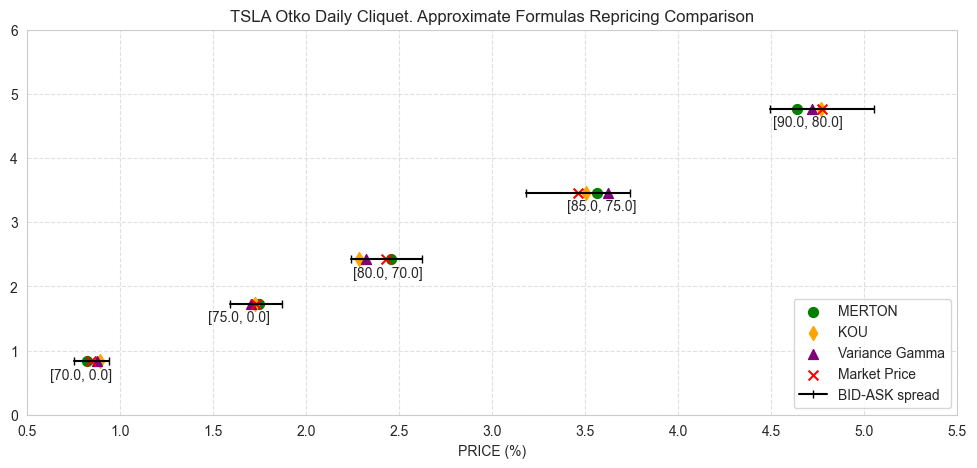

In [114]:

fig, ax = plt.subplots(figsize=(12, 5))
plt.scatter(merton_cf_prices, mkt_prices, label='MERTON', color='green', marker='o', s=50)
# Add scatter points for otko_kou_repriced_3 and otko_vg_repriced_3
plt.scatter(kou_cf_prices, mkt_prices, label='KOU', color='orange', marker='d', s=50)
plt.scatter(vg_cf_prices, mkt_prices, label='Variance Gamma', color='purple', marker='^', s=50)

# Adding labels for the points
for i in range(len(strikes)):
    offset_x = -13
    offset_y = -13
    plt.annotate(f"[{strikes[i][0] * 100}, {strikes[i][1] * 100}]", (merton_mc_prices[i], mkt_prices[i]),
                 textcoords="offset points",
                 xytext=(offset_x, offset_y))

# Adding a reference line
plt.scatter(mkt_prices, mkt_prices, color='red', marker='x', label='Market Price', s=50)

# Plot segments between bid, ask, and calibrated prices
for i in range(len(strikes)):
    plt.plot([otko_tsla['BID(%)'][i], otko_tsla['ASK(%)'][i]], [mkt_prices[i], mkt_prices[i]], color='black',
             linestyle='-', marker='|')

# Adding labels and title
plt.xlabel('PRICE (%)')
plt.title('TSLA Otko Daily Cliquet. Approximate Formulas Repricing Comparison')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
line = Line2D([0], [0], label='BID-ASK spread', color='k', linestyle='-', drawstyle='steps-post', marker='|')
handles.append(line)
ax.legend(handles=handles, loc='lower right')
ax.grid(True, linestyle='--', alpha=0.6)


# Remove x_ticks and y_ticks
ax.set_xticks(np.linspace(0.5, 5.5, 11))
ax.set_yticks(np.linspace(0, 6, 7))
# Show the chart

plt.show()

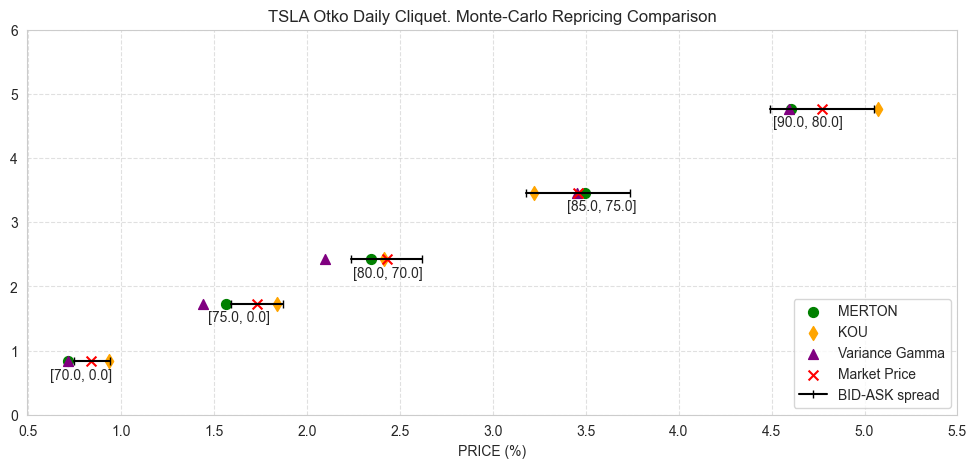

In [115]:

fig, ax = plt.subplots(figsize=(12, 5))
plt.scatter(merton_mc_prices, mkt_prices, label='MERTON', color='green', marker='o', s=50)
# Add scatter points for otko_kou_repriced_3 and otko_vg_repriced_3
plt.scatter(kou_mc_prices, mkt_prices, label='KOU', color='orange', marker='d', s=50)
plt.scatter(vg_mc_prices, mkt_prices, label='Variance Gamma', color='purple', marker='^', s=50)

# Adding labels for the points
for i in range(len(strikes)):
    offset_x = -13
    offset_y = -13
    plt.annotate(f"[{strikes[i][0] * 100}, {strikes[i][1] * 100}]", (merton_mc_prices[i], mkt_prices[i]),
                 textcoords="offset points",
                 xytext=(offset_x, offset_y))

# Adding a reference line
plt.scatter(mkt_prices, mkt_prices, color='red', marker='x', label='Market Price', s=50)

# Plot segments between bid, ask, and calibrated prices
for i in range(len(strikes)):
    plt.plot([otko_tsla['BID(%)'][i], otko_tsla['ASK(%)'][i]], [mkt_prices[i], mkt_prices[i]], color='black',
             linestyle='-', marker='|')

# Adding labels and title
plt.xlabel('PRICE (%)')
plt.title('TSLA Otko Daily Cliquet. Monte-Carlo Repricing Comparison')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
line = Line2D([0], [0], label='BID-ASK spread', color='k', linestyle='-', drawstyle='steps-post', marker='|')
handles.append(line)
ax.legend(handles=handles, loc='lower right')
ax.grid(True, linestyle='--', alpha=0.6)


# Remove x_ticks and y_ticks
ax.set_xticks(np.linspace(0.5, 5.5, 11))
ax.set_yticks(np.linspace(0, 6, 7))
# Show the chart

plt.show()